# Irish Wind Data 

In this Notebook, we follow Tilmanm  Gneiting experiment as presented in his paper: [Nonseparable, stationary Covariance Functions for Space-Time Data](http://www.jstor.org/stable/3085674).

The Irish wind data consist of daily averages of wind speeds at 12 synoptic meteorological stations in Ireland during the period 1961-1978. Gneiting in his experiment used data from 11 stations, he excluded data from Roslare station. We follow his experiment, by first loading the data into the data frame. We do a square root transformation of the data to make the marginal distributions approximately normal. We then proceed to calculate empirical correlation and plot empirical space-time correlation graphs as in Figure 5 in Gneiting paper. We then fit the data to proposed covariance model and compare results with the results presented in Gneiting paper.


In [1]:
#Import statements
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

pd.options.display.max_rows = 12 #Setting the maximal number of displayed rows for a dataframe 

# Graphing helper function
def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

In [2]:
#Read the data into a dataframe

df = pd.read_csv('Ireland_wind_data.csv', names=['Year', 'Month', 'Day', 'RPT', 'VAL', 'ROS', 
                                                 'KIL', 'SHA', 'BIR', 'DUB', 'CLA', 'MUL', 'CLO', 'BEL', 'MAL'],
                delim_whitespace=True)
#Fix years
df['Year'] += 1900
df

,Year,Month,Day,RPT,VAL,ROS,KIL,SHA,BIR,DUB,CLA,MUL,CLO,BEL,MAL
0,1961,1,1,15.04,14.96,13.17,9.29,13.96,9.87,13.67,10.25,10.83,12.58,18.50,15.04
1,1961,1,2,14.71,16.88,10.83,6.50,12.62,7.67,11.50,10.04,9.79,9.67,17.54,13.83
2,1961,1,3,18.50,16.88,12.33,10.13,11.17,6.17,11.25,8.04,8.50,7.67,12.75,12.71
3,1961,1,4,10.58,6.63,11.75,4.58,4.54,2.88,8.63,1.79,5.83,5.88,5.46,10.88
4,1961,1,5,13.33,13.25,11.42,6.17,10.71,8.21,11.92,6.54,10.92,10.34,12.92,11.83
5,1961,1,6,13.21,8.12,9.96,6.67,5.37,4.50,10.67,4.42,7.17,7.50,8.12,13.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6568,1978,12,26,13.83,11.87,10.34,2.37,6.96,4.29,1.96,3.79,3.04,3.08,4.79,11.96
6569,1978,12,27,17.58,16.96,17.62,8.08,13.21,11.67,14.46,15.59,14.04,14.00,17.21,40.08
6570,1978,12,28,13.21,5.46,13.46,5.00,8.12,9.42,14.33,16.25,15.25,18.05,21.79,41.46


In [3]:
#Square root transformation and changing knots to meters per second

#Roslare Ros is not used in Tilmann analysis due to being uncorrelated to the rest of the stations

df_wind_data = df[['RPT', 'VAL', 'KIL', 'SHA', 'BIR', 'DUB', 'CLA', 'MUL', 'CLO', 'BEL', 'MAL']]

for column in df_wind_data:
    df[column] = np.sqrt(df[column] * 0.514444444)

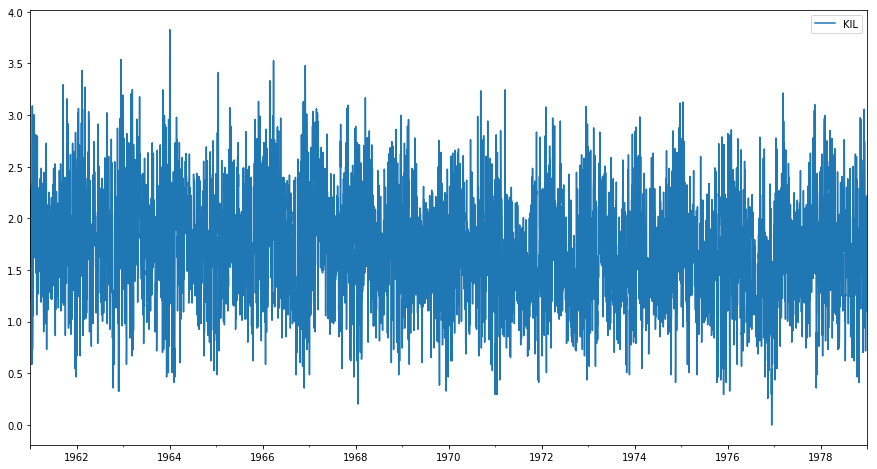

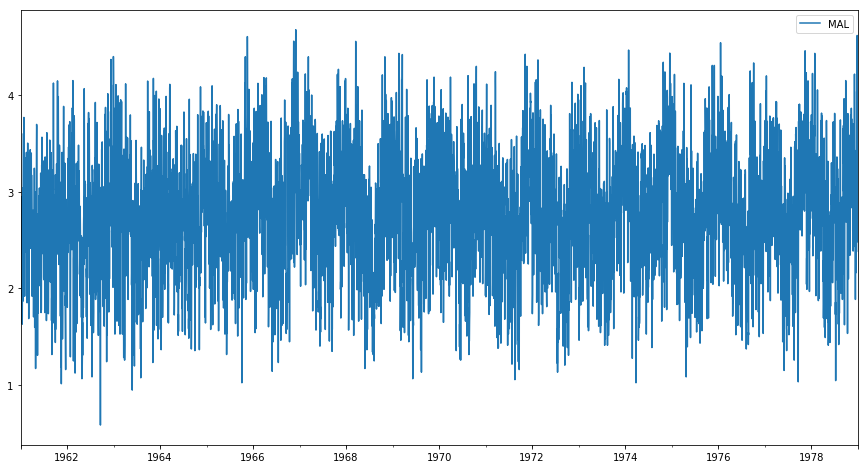

In [4]:
#Testing if ploting data works
df.plot(x=pd.to_datetime(df[['Year', 'Month', 'Day']]), y='KIL', figsize=(15,8) )
df.plot(x=pd.to_datetime(df[['Year', 'Month', 'Day']]), y='MAL', figsize=(15,8) )

In [5]:
#Printing the mean value at Roche's Point to compare the results to the in Table 3
print(df['RPT'].mean())

2.45457157796


In [6]:
#Read location file
df_local = pd.read_csv('Ireland_wind_location.csv', names=["Station","Code","Latitude","Longitude","MeanWind"])
print(df_local)

              Station            Code       Latitude  Longitude  \
Roche's Point     RPT         51d48'N         8d15'W       6.36   
Valentia          VAL         51d56'N        10d15'W       5.48   
Roslare           ROS  52d16'56.791"N  6d21'25.056"W       6.00   
Kilkenny          KIL         52d40'N         7d16'W       3.25   
Shannon           SHA         52d42'N         8d55'W       5.38   
Birr              BIR         53d05'N         7d53'W       3.65   
Dublin            DUB         53d26'N         6d15'W       5.05   
Claremorris       CLA         53d43'N         8d59'W       4.32   
Mullingar         MUL         53d32'N         7d22'W       4.38   
Clones            CLO         54d11'N         7d14'W       4.48   
Belmullet         BEL         54d14'N        10d00'W       6.75   
Malin Head        MAL         55d22'N         7d20'W       8.03   

                       MeanWind  
Roche's Point    N 51.48 W 8.15  
Valentia                N 51.56  
Roslare            N52.16 

In [7]:
#Reading file with distance between stations in km
df_distances = pd.read_csv('Ireland_wind_distances.csv')
print(df_distances)

       'RPT'   'VAL'   'KIL'   'SHA'   'BIR'   'DUB'   'CLA'   'MUL'   'CLO'  \
'RPT'      0     129     123     108     180     240     219     214     300   
'VAL'    129       0     216     138     236     323     229     272     343   
'KIL'    123     216       0      95      77     117     150     102     190   
'SHA'    108     138      95       0      98     187     112     134     210   
'BIR'    180     236      77      98       0      95      82      37     121   
'DUB'    240     323     117     187      95       0     164      72     115   
'CLA'    219     229     150     112      82     164       0      92     122   
'MUL'    214     272     102     134      37      72      92       0      88   
'CLO'    300     343     190     210     121     115     122      88       0   
'BEL'    325     287     278     219     212     282     130     214     197   
'MAL'    421     448     314     324     243     229     219     211     124   

        'BEL'   'MAL'  
'RPT'     325  

(0, 1)

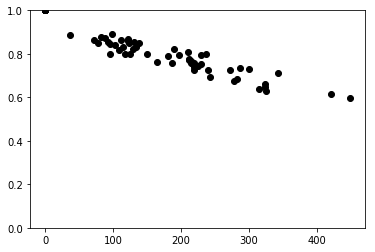

In [8]:
# calculating the covariance for zero lag
i = 0

y0 = [None] * 66
x0 = [None] * 66
k=0
for first_column in df_wind_data:
    df1 = df[first_column]
    std_test1=np.std(df1)
    j = 0 
    for second_column in df_wind_data:
        if j <= i:
            df2 = df[second_column]
            std_test2=np.std(df2)
            y0[k] = (np.cov(df1,df2)/(std_test1*std_test2)).item((0, 1))
            x0[k] = df_distances.iloc[i,j]
            j = j + 1
            k = k + 1
    i = i + 1
plt.scatter(x0, y0,  color='black')
plt.ylim(0, 1)


(0, 1)

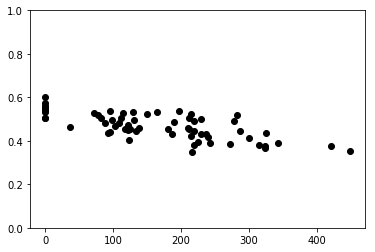

In [9]:
# calculating the covariance for one day lag 
y1 = [None] * 66
x1 = [None] * 66
i=0
k=0
for first_column in df_wind_data:
    df1 = df[first_column][:-1]
    std_test1=np.std(df1)
    j = 0 
    for second_column in df_wind_data:
        if j <= i:
            df2 = df[second_column][1:]
            std_test2=np.std(df2)
            y1[k] = (np.cov(df1,df2)/(std_test1*std_test2)).item((0, 1))
            x1[k] = df_distances.iloc[i,j]
            j = j + 1
            k = k + 1
    i = i + 1
plt.scatter(x1, y1,  color='black')
plt.ylim(0, 1)


(0, 1)

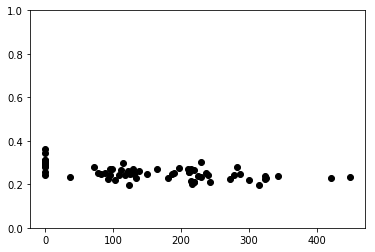

In [10]:
# calculating the covariance for two days lag
y2 = [None] * 66
x2 = [None] * 66
i = 0
k=0
for first_column in df_wind_data:
    df1 = df[first_column][:-2]
    std_test1=np.std(df1)
    j = 0 
    for second_column in df_wind_data:
        if j <= i:
            df2 = df[second_column][2:]
            std_test2=np.std(df2)
            y2[k] = (np.cov(df1,df2)/(std_test1*std_test2)).item((0, 1))
            x2[k] = df_distances.iloc[i,j]
            j = j + 1
            k = k + 1
    i = i + 1
plt.scatter(x2, y2,  color='black')
plt.ylim(0, 1)


(0, 1)

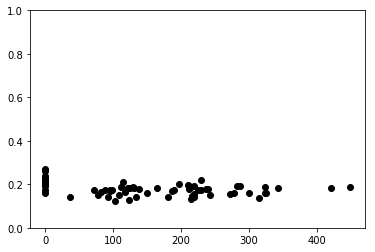

In [11]:
# calculating the covariance for three days lag 
y3 = [None] * 66
x3 = [None] * 66
i = 0
k=0
for first_column in df_wind_data:
    df1 = df[first_column][:-3]
    std_test1=np.std(df1)
    j = 0 
    for second_column in df_wind_data:
        if j <= i:
            df2 = df[second_column][3:]
            std_test2=np.std(df2)
            y3[k] = (np.cov(df1,df2)/(std_test1*std_test2)).item((0, 1))
            x3[k] = df_distances.iloc[i,j]
            j = j + 1
            k = k + 1
    i = i + 1
plt.scatter(x3, y3,  color='black')
plt.ylim(0, 1)


In [12]:
#Fitting the curve for spatial seperation
def func(x, a, b):
    return a * np.exp(-b * x)

popt, pcov = curve_fit(func, x0, y0, bounds=(0, [1, 0.1]))
popt

array([ 0.97749118,  0.00118312])

In [13]:
#Testing the curve fitting for temporal seperation
def func(x, a, b):
    return (a * x**b  +  1)**(-1)

testy = [sum(y1)/len(y1), sum(y2)/len(y2),sum(y3)/len(y3)]

testy_paper = [0.526,0.267,0.179] #average emperical time lags correlations observation from the paper 

testx = [1,2,3]

popt, pcov = curve_fit(func, testx, testy, bounds=(0, [0.901, 2.]))
print(popt)

popt, pcov = curve_fit(func, testx, testy_paper, bounds=(0, [0.901, 2.]))
print(popt)

[ 0.901       1.58418681]
[ 0.901       1.53633464]


In our analysis, we got slightly different results in comparison to Gneting analysis.

Covariance function as presented in paper:

\begin{equation} C(\mathbf{h},t)=\frac{0.968 \exp(-0.00134 ||\mathbf{h}||)}{0.901 t^{1.544} +1}  \end{equation}

Our result:

\begin{equation} C(\mathbf{h},t)=\frac{0.978 \exp(-0.0012 ||\mathbf{h}||)}{0.901 t^{1.589} +1}  \end{equation}


The difference is probably due to a different method of fitting the covariance functions and different results in the average for time lags.